<a href="https://colab.research.google.com/github/Morningstar1998/emotion_classification_keras/blob/main/Fasttext_dataset_profe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive  

Mounted at /content/gdrive


In [ ]:
!pip install datasets
from datasets import load_dataset
dataset = load_dataset(
   'emotion')

In [ ]:
!pip install -q tensorflow-text
!pip install -q tf-models-official
!pip install -q sklearn

In [ ]:
!pip install tensorflow-text
import tensorflow_text as text

In [ ]:
import tensorflow as tf
import tensorflow_text as text


from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM,SimpleRNN,GRU,RNN
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from numpy import array
from numpy import asarray
from numpy import zeros


import tensorflow_hub as hub
import tensorflow as tf
from official.nlp import optimization 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle


In [ ]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [ ]:
def adding_new_data(dataframe_input):
  place=0
  for sent in dataframe_input['sentiment']:
    if sent==0:
      dataframe_input['sadness'][place]=1
    elif sent==1:
      dataframe_input['joy'][place]=1
    elif sent==2:
      dataframe_input['love'][place]=1
    elif sent==3:
      dataframe_input['anger'][place]=1
    elif sent==4:
      dataframe_input['fear'][place]=1
    elif sent==5:
      dataframe_input['unsolve'][place]=1
    place += 1
  dataframe_input['sadness']=dataframe_input['sadness'].replace(np.nan, 0)
  dataframe_input['joy']=dataframe_input['joy'].replace(np.nan, 0)
  dataframe_input['love']=dataframe_input['love'].replace(np.nan, 0)
  dataframe_input['anger']=dataframe_input['anger'].replace(np.nan, 0)
  dataframe_input['fear']=dataframe_input['fear'].replace(np.nan, 0)
  dataframe_input['unsolve']=dataframe_input['unsolve'].replace(np.nan,0)
  return dataframe_input


In [ ]:
def data (dataset_raw,x):
  data=dataset_raw[x]
  labels=data['label']
  text=data['text']
  text=np.array([text])
  labels=np.array([labels])
  data4=pd.DataFrame([text[0],labels[0]])
  data4=data4.T
  data4.columns=['text','sentiment']
  data4["sadness"] = np.nan
  data4["joy"] = np.nan
  data4["love"] = np.nan
  data4["anger"] = np.nan
  data4["fear"] = np.nan
  data4["unsolve"] = np.nan
  data4=adding_new_data(data4)
  return data4

In [ ]:
train=data (dataset,'train')
test=data (dataset,'test')
validation=data (dataset,'validation')

In [ ]:
train.to_csv('train.csv')
test.to_csv('test.csv')
validation.to_csv('validation.csv')

In [ ]:
train.head(10)

,text,sentiment,sadness,joy,love,anger,fear,unsolve
0,i didnt feel humiliated,0,1.0,0.0,0.0,0.0,0.0,0.0
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,0,1.0,0.0,0.0,0.0,0.0,0.0
2,im grabbing a minute to post i feel greedy wrong,3,0.0,0.0,0.0,1.0,0.0,0.0
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,2,0.0,0.0,1.0,0.0,0.0,0.0
4,i am feeling grouchy,3,0.0,0.0,0.0,1.0,0.0,0.0
5,ive been feeling a little burdened lately wasnt sure why that was,0,1.0,0.0,0.0,0.0,0.0,0.0
6,ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny,5,0.0,0.0,0.0,0.0,0.0,1.0
7,i feel as confused about life as a teenager or as jaded as a year old man,4,0.0,0.0,0.0,0.0,1.0,0.0
8,i have been with petronas for years i feel that petronas has performed well and made a huge profit,1,0.0,1.0,0.0,0.0,0.0,0.0
9,i feel romantic too,2,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
print(train.size)

128000


In [ ]:
concat_data=[train,test,validation]
train = pd.concat(concat_data)

In [ ]:
train

In [ ]:
print(train.size)

160000


In [ ]:
place=168
filter = train["text"] != ""
train = train[filter]
train = train.dropna()
print('text: ' + train["text"][place])
print("label:" + str(train["sentiment"][place]))

168                                                                                                                 text: i want to hold this feeling of shocked awe and wonder forever
168                                                                  text: i lost a few people which i hate because i have a really hard time letting go of people to whom i feel loyal
168    text: i didn t feel frightened i m rarely scared of any place but i couldn t help feeling uneasy in the company of so many big groups of men and the only woman visible anywhere
Name: text, dtype: object
label:168    5
168    2
168    4
Name: sentiment, dtype: object


In [ ]:
#train_labels = train[["sadness", "joy", "love",'anger','fear','unsolve']]
#train_labels = train[["love",'anger','fear']]
train_labels = train[["sadness", "joy"]]
classes=train_labels.shape
classes=classes[1]
print(classes)
train_labels.head()

2


,sadness,joy
0,1.0,0.0
1,1.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


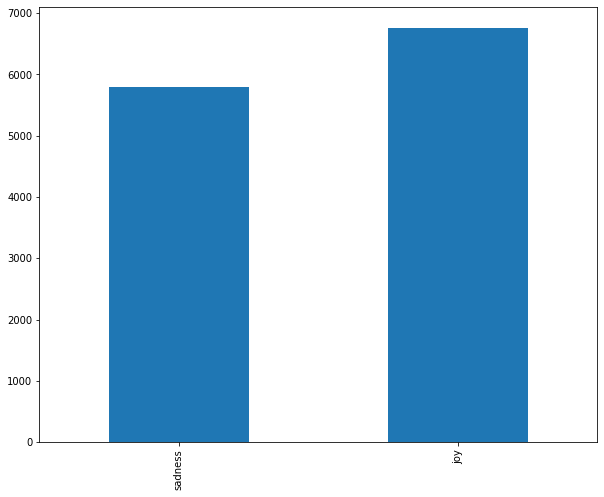

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
train_labels.sum(axis=0).plot.bar()

In [ ]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [ ]:
X = []
sentences = list(train["text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = train_labels.values

In [ ]:
X[1:10]

['i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing minute to post feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep lot faster but also feel like so funny',
 'i feel as confused about life as teenager or as jaded as year old man',
 'i have been with petronas for years feel that petronas has performed well and made huge profit',
 'i feel romantic too']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print(y_train)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(X_train)

['i was getting motivated about losing weight and getting healthy and wearing that outfit and feeling fantastic', 'i feel very delighted for my stay here in manila is nearing its end and feel so down for the same reason', 'i didnt respond because feel that some days cant just put on fake smile and pretend like life is great and not let the negativity creep in', 'i have succumbed to the dreaded commuter virus and feel altogether little bit rotten', 'i feel like wow that very cool that could be me', 'i sneeze have dark circles under my eyes feel miserable really', 'i like when im feeling productive even though sometimes grumble about not having time to scratch my butt', 'i know that will find job and god has plan but im feeling little uncertain about everything at the moment', 'i am not even sure how to formulate my thoughts since just put it down and am feeling slightly overwhelmed', 'i also hate feeling aggravated when dont know how am supposed to eat because when feel that way often s

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train)

[[1, 18, 177, 25, 960, 612, 3, 177, 822, 3, 866, 7, 3, 6, 823], [1, 2, 43, 856, 15, 9, 613, 130, 10, 20, 80, 224, 3, 2, 13, 138, 15, 5, 210, 324], [1, 135, 35, 2, 7, 67, 148, 127, 30, 253, 28, 757, 824, 3, 12, 75, 20, 302, 3, 24, 195, 5, 10], [1, 17, 4, 5, 3, 2, 52, 78, 725], [1, 2, 12, 7, 43, 378, 7, 90, 26, 16], [1, 17, 602, 9, 399, 2, 427, 39], [1, 12, 31, 14, 6, 603, 70, 128, 172, 25, 24, 147, 49, 4, 9], [1, 45, 7, 57, 154, 328, 3, 226, 96, 583, 19, 14, 6, 52, 463, 25, 164, 32, 5, 233], [1, 22, 24, 70, 156, 51, 4, 9, 370, 203, 30, 253, 11, 138, 3, 22, 6, 331, 234], [1, 112, 235, 6, 31, 86, 45, 51, 22, 726, 4, 490, 35, 31, 2, 7, 87, 228, 7, 87], [1, 201, 4, 613, 23, 9, 113, 454, 15, 62, 23, 62, 23, 62, 3, 172, 279, 25, 62], [1, 2, 7, 3, 342, 3, 3, 20], [1, 2, 12, 147, 7, 238, 220, 343, 24, 30, 32, 19, 228, 15], [1, 2, 131, 289, 25], [1, 107, 6, 257, 6, 12, 8, 10, 9, 356, 3, 31, 552, 136, 867, 12, 31, 88, 66, 881], [1, 135, 64, 4, 26, 239, 8, 813, 30, 4, 2, 271], [1, 325, 47, 60, 419

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = None

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
print(X_train[1])

[  1   2  43 856  15   9 613 130  10  20  80 224   3   2  13 138  15   5
 210 324   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]


In [ ]:
print(X_train[2])

[  1 135  35   2   7  67 148 127  30 253  28 757 824   3  12  75  20 302
   3  24 195   5  10   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]


In [ ]:
print(X_train[3])

[  1  17   4   5   3   2  52  78 725   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]


In [ ]:
embedding_dim_fasttext = 300
embeddings_index_fasttext = {}
word_index=tokenizer.word_index
f = open('/content/gdrive/MyDrive/Clasificador/wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
  values = line.split()
  word = values[0]
  embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()
print(len(word_index) + 1)
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
  embedding_vector = embeddings_index_fasttext.get(word)
  if embedding_vector is not None:
    embedding_matrix_fasttext[i] = embedding_vector
#print(embedding_matrix_fasttext)

15171


In [ ]:
deep_inputs = Input(shape=(None,))
net = Embedding(vocab_size, 300, weights=[embedding_matrix_fasttext], trainable=False,mask_zero=True,name = 'embeddings')(deep_inputs)

#activations
#act='relu'
act='sigmoid'
#act=activation=tf.keras.activations.softmax

#Layer 1
net = LSTM(150,name='lstm_layer_1',return_sequences=True)(net)
net = SimpleRNN(150, return_sequences=True,name='RNN_1')(net)
net = GRU(150, return_sequences=True,name='GRU_1')(net)

#Layer 2
#net = LSTM(200,name='lstm_layer_2',return_sequences=True)(net)
#net = (SimpleRNN(200, return_sequences=True,name='RNN_2'))(net)
#net = GRU(200, return_sequences=True,name='GRU_2')(net)

#Layer 3
net = LSTM(200,name='lstm_layer_3')(net)

#net = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation=None, kernel_initializer='he_uniform')(net)
#net = tf.keras.layers.MaxPooling1D(3)(net)
#net = tf.keras.layers.GlobalMaxPool1D()(net)
#net = tf.keras.layers.BatchNormalization()(net)

net=tf.keras.layers.Dropout(0.3)(net)

#net = Dense(25,activation=None)(net)
#net = Dense(12,activation=None)(net)
#net = Dense(6,activation=None)(net)

net = Dense(classes,activation=act)(net)
model2= Model(inputs=deep_inputs, outputs=net)

#optimizers
#opt = tf.optimizers.Adam(learning_rate=0.01)
#opt='rmsprop'
#opt=tf.keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False,name="RMSprop")
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
opt = keras.optimizers.SGD(learning_rate=lr_schedule)

#loss
l='binary_crossentropy'
#l='categorical_crossentropy'

model2.compile(loss=l, optimizer=opt, metrics=['acc'])
print(model2.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embeddings (Embedding)       (None, None, 300)         4551300   
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 150)         270600    
_________________________________________________________________
RNN_1 (SimpleRNN)            (None, None, 150)         45150     
_________________________________________________________________
GRU_1 (GRU)                  (None, None, 150)         135900    
_________________________________________________________________
lstm_layer_3 (LSTM)          (None, 200)               280800    
_________________________________________________________________
tf.identity (TFOpLambda)     (None, 200)               0     

In [ ]:
history = model2.fit(X_train, y_train, batch_size=24, epochs=30, validation_split=0.2)

In [ ]:
score = model2.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

125/125 [==============================] - 4s 12ms/step - loss: 0.2907 - acc: 0.8015
Test Score: 0.29068154096603394
Test Accuracy: 0.8015000224113464


In [ ]:
def convert2embeding (word):
  X = []
  sentences = list(word)
  #print(sentences)
  for sen in sentences:
    X.append(preprocess_text(sen))
  #print(X)
  token_word=tokenizer.texts_to_sequences(X[0])
  #print(token_word)
  final=[]
  for tok in token_word:
    try:
      final.append(tok[0])
    except:
      final.append(0)
  #print(final)
  maxlen = 32
  final_word = pad_sequences([final], padding='post', maxlen=maxlen)
  #print(final_word)
  return final_word
word2='Beatiful world baby'
x=convert2embeding ([word2])
print(x)

[[  0   0 515   0   1   0   0   0   0   0   0   0   0 901   0   0 515   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [ ]:
path='/content/gdrive/MyDrive/Clasificador/fasttext_dataset_hugging.h5'
model2.save(path)
new_model = keras.models.load_model(path)

In [ ]:
["sadness", "joy", "love",'anger','fear','unsolve']

In [ ]:
#Many
y='beatiful world baby'
x2=convert2embeding([y])
a = model2.predict(x2)
print(y,' ',a)
y='hate you'
x2=convert2embeding([y])
a = model2.predict(x2)
print(y,'---- ',a)
y='very bored'
x2=convert2embeding([y])
a = model2.predict(x2)
print(y,'---- ',a)
y='i was so happy back then'
x2=convert2embeding([y])
a = model2.predict(x2)
print(y,'---- ',a)
y='i am so happy'
x2=convert2embeding([y])
a = model2.predict(x2)
print(y,'---- ',a)
y='is so scary'
x2=convert2embeding([y])
a = model2.predict(x2)
print(y,'---- ',a)
y='i hate my life'
x2=convert2embeding([y])
a = model2.predict(x2)
print(y,'---- ',a)
y='i love you'
x2=convert2embeding([y])
a = model2.predict(x2)
print(y,'---- ',a)
y='let´s party all night!!!!'
x2=convert2embeding([y])
a = model2.predict(x2)
print(y,'---- ',a)
y='lets have some fun baby'
x2=convert2embeding([y])
a = model2.predict(x2)
print(y,'---- ',a)
y='i want to kill myself'
x2=convert2embeding([y])
a = model2.predict(x2)
print(y,'---- ',a)
y='fucking bitch'
x2=convert2embeding([y])
a = model2.predict(x2)
print(y,'---- ',a)
y= 'i am so sad'
x2=convert2embeding([y])
a = model2.predict(x2)
print(y,'---- ',a)
y= 'i used to be happy'
x2=convert2embeding([y])
a = model2.predict(x2)
print(y,'---- ',a)

beatiful world baby   [[0.07193025 0.6885218 ]]
hate you ----  [[0.29399747 0.45724174]]
very bored ----  [[0.2582703 0.5333489]]
i was so happy back then ----  [[0.07733497 0.6116134 ]]
i am so happy ----  [[0.13652903 0.4690887 ]]
is so scary ----  [[0.24529666 0.43578008]]
i hate my life ----  [[0.17475216 0.4104598 ]]
i love you ----  [[0.35733598 0.39953974]]
let´s party all night!!!! ----  [[0.08012608 0.59389883]]
lets have some fun baby ----  [[0.10948037 0.5100384 ]]
i want to kill myself ----  [[0.18543883 0.40825018]]
fucking bitch ----  [[0.304326  0.3765295]]
i am so sad ----  [[0.09206086 0.5987609 ]]
i used to be happy ----  [[0.10527819 0.69670045]]


In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')